In [76]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix,roc_curve, roc_auc_score, auc, accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from itertools import cycle
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Functions

In [77]:
def train_test_split_per_user(data, train_size=0.7, target_column='label_negative_affect_category'):
    users = list(set(data.id))
    users = sorted(users, reverse=True)  # fix randomness
    total_users = len(users)
    slice_idx = int(train_size * total_users)
    users_train = users[:slice_idx]
    users_test = users[slice_idx:]
    
    # Split data based on user IDs
    train_data = data[data.id.isin(users_train)]
    test_data = data[data.id.isin(users_test)]
    
    x_train = train_data.drop(['id', target_column], axis=1) 
    y_train = train_data[target_column]  
    x_test = test_data.drop(['id', target_column], axis=1) 
    y_test = test_data[target_column]  
    
    return x_train, y_train, x_test, y_test

In [78]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [79]:
custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
complementary_colors = ['#a9d0f5', '#f3ba8c', '#98e698', '#f5a9a9', '#d8b5d8', '#d2a6a6', '#f5a9f2', '#d8d8d8']

full_palette = custom_colors + complementary_colors
sns.set_palette(full_palette)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 15

In [80]:
df = pd.read_pickle('../data/lifesnaps/lifesnapsv2.pkl')
df['id'] = df['id'].astype(str)
df = df[df['label_negative_affect_category'].notna()]
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_stress_sema,label_negative_affect_category,label_stai_stress_category
0,621e332267b776a24092a584,34.036874,57.4370,37.914,95.60,17.2,0.0,0.000000,0.000,0.000000,...,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,NaN,1,1
1,621e30e467b776a240e817c7,33.274919,52.5365,38.161,94.50,17.2,0.0,0.000000,0.000,0.000000,...,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1.0,1,1
2,621e367e67b776a24087d75d,33.019585,62.9565,32.762,96.00,12.0,72.0,0.733333,0.700,0.700000,...,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,NaN,1,1
3,621e360b67b776a24039709f,34.175203,68.3210,31.413,96.00,15.4,69.0,0.633333,0.650,0.800000,...,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,NaN,1,1
4,621e2f6167b776a240e082a9,34.892637,62.5580,24.507,97.20,13.0,68.0,0.666667,0.625,0.666667,...,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,NaN,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,621e300767b776a2404dc717,33.186399,62.3900,34.057,95.85,15.0,72.0,0.733333,0.700,0.700000,...,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,NaN,1,1
4905,621e309b67b776a240b532b0,31.815133,62.3900,34.057,96.00,15.0,72.0,0.733333,0.700,0.700000,...,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,NaN,1,1
4906,621e342e67b776a2404ce460,33.864390,51.0640,80.576,96.00,17.2,66.0,0.533333,0.650,0.700000,...,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,NaN,1,1
4907,621e309267b776a240ae1cdb,34.121912,62.3900,34.057,96.00,15.0,72.0,0.733333,0.700,0.700000,...,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,NaN,1,1


In [81]:
df['label_negative_affect_category'].value_counts()

1    4738
0      98
2      73
Name: label_negative_affect_category, dtype: int64

In [82]:
df = df.drop(columns=['label_stai_stress_category', 'label_stress_sema' ])
df

,id,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,responsiveness_points_percentage,...,bmi,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,label_negative_affect_category
0,621e332267b776a24092a584,34.036874,57.4370,37.914,95.60,17.2,0.0,0.000000,0.000,0.000000,...,1,-0.866025,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1
1,621e30e467b776a240e817c7,33.274919,52.5365,38.161,94.50,17.2,0.0,0.000000,0.000,0.000000,...,3,-0.866025,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1
2,621e367e67b776a24087d75d,33.019585,62.9565,32.762,96.00,12.0,72.0,0.733333,0.700,0.700000,...,3,-0.866025,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1
3,621e360b67b776a24039709f,34.175203,68.3210,31.413,96.00,15.4,69.0,0.633333,0.650,0.800000,...,0,-0.866025,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1
4,621e2f6167b776a240e082a9,34.892637,62.5580,24.507,97.20,13.0,68.0,0.666667,0.625,0.666667,...,2,-0.866025,0.0,0.309017,-0.988468,0.5,1.0,0.951057,0.151428,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4904,621e300767b776a2404dc717,33.186399,62.3900,34.057,95.85,15.0,72.0,0.733333,0.700,0.700000,...,2,0.866025,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,1
4905,621e309b67b776a240b532b0,31.815133,62.3900,34.057,96.00,15.0,72.0,0.733333,0.700,0.700000,...,1,0.866025,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,1
4906,621e342e67b776a2404ce460,33.864390,51.0640,80.576,96.00,17.2,66.0,0.533333,0.650,0.700000,...,2,0.866025,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,1
4907,621e309267b776a240ae1cdb,34.121912,62.3900,34.057,96.00,15.0,72.0,0.733333,0.700,0.700000,...,0,0.866025,0.0,0.809017,-0.299363,0.5,1.0,0.587785,-0.954139,1


In [83]:
X_train, y_train, X_test, y_test = train_test_split_per_user(df,target_column='label_negative_affect_category')

In [84]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3310, 46) (3310,) (1599, 46) (1599,)


In [85]:
# Initialize SMOTE
smote = SMOTE(random_state=42)
# Fit SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Now X_train_smote and y_train_smote have balanced classes

In [86]:
clf = RandomForestClassifier(random_state=42)
#clf = XGBClassifier()

clf.fit(X_train_smote, y_train_smote)  # Use the resampled data
y_pred = clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9643527204502814
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        36
           1       0.96      1.00      0.98      1543
           2       0.00      0.00      0.00        20

    accuracy                           0.96      1599
   macro avg       0.32      0.33      0.33      1599
weighted avg       0.93      0.96      0.95      1599

[[   0   36    0]
 [   1 1542    0]
 [   0   20    0]]


C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ChristinaKaragianni\anaconda3\envs\py38\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

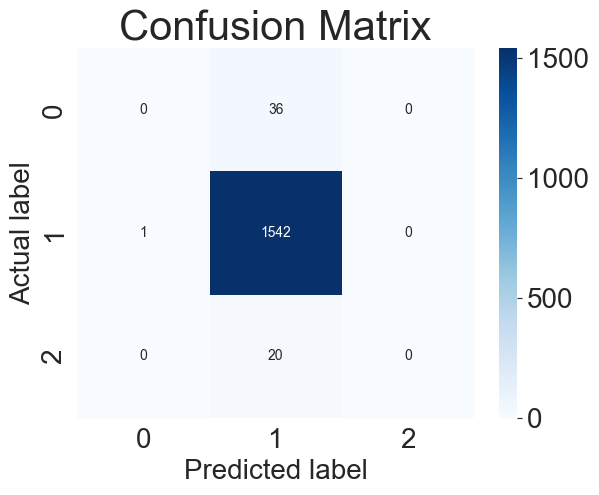

In [87]:
plot_confusion_matrix(y_test, y_pred)

# ROC AUC curve
First, we need to predict class probabilities rather than class labels for the test set. This is because the ROC curve requires probabilities to compute the true positive rate and false positive rate at various thresholds.

In [88]:
y_prob = clf.predict_proba(X_test)  # matrix of probabilities

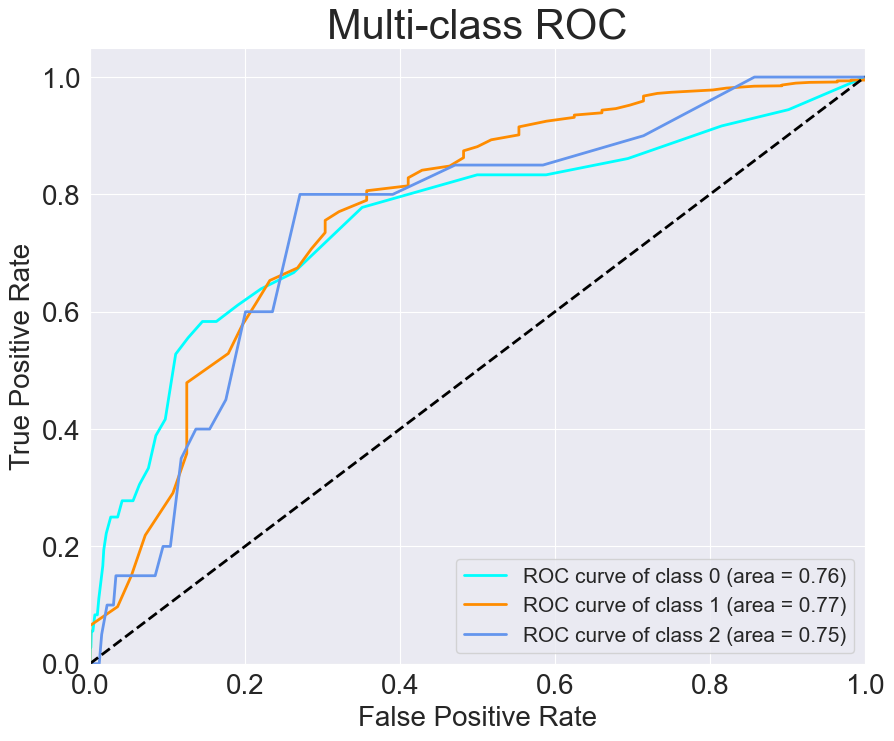

In [89]:
# Binarize the output labels for multi-class ROC AUC
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_binarized.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plotting
plt.figure(figsize=(10, 8))
lw = 2
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()